In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r"/content/spotify_global_2019_most_streamed_tracks_audio_features.csv")
df.rename(columns = {'danceability':'Y', 'mode':'T'}, inplace = True)

In [3]:
df = pd.get_dummies(df, columns=['Artist', 'key'])
x_features = df.columns.difference(['T', 'Y'])
X = df[x_features]
T_df = df['T']

In [4]:
kmeans = make_pipeline(StandardScaler(), KMeans(120, random_state=42))
kmeans.fit(X)
identified_clusters = kmeans.fit_predict(X)
df['Clusters'] = identified_clusters
total = 0
count = 0
lengths = []
for i in range(150):
  curr_Y0 = df[df['Clusters'] == i][df['T'] == 0]['Y']
  curr_Y1 = df[df['Clusters'] == i][df['T'] == 1]['Y']
  if len(curr_Y0) > 1 and len(curr_Y0) <= 20:
    total += len(curr_Y0) * (max(curr_Y0) - min(curr_Y0))
    count += len(curr_Y0)
    lengths.append(len(curr_Y0))
  if len(curr_Y1) > 1 and len(curr_Y1) <= 20:
    total += len(curr_Y1) * (max(curr_Y1) - min(curr_Y1))
    count += len(curr_Y1)
    lengths.append(len(curr_Y1))
print("weighted average range:", total / count)
print("mean cluster length:", sum(lengths) / len(lengths))
df.drop(columns=['Clusters'], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


weighted average range: 0.28688926553672334
mean cluster length: 5.175438596491228


In [5]:
total = 0
count = 240
for i in range(120):
  sampled_0 = df[df['T'] == 0].sample(5, random_state=i)['Y']
  sampled_1 = df[df['T'] == 1].sample(5, random_state=i)['Y']
  total += max(sampled_0) - min(sampled_0) + max(sampled_1) - min(sampled_1)
print(total / count)

0.35635


**Estimating Propensity Score**

In [6]:
model = make_pipeline(StandardScaler(), CalibratedClassifierCV(LogisticRegression()))
prop_model = model.fit(X, T_df)
df['P'] = prop_model.predict_proba(X)[:, 1]
P_df = df['P']

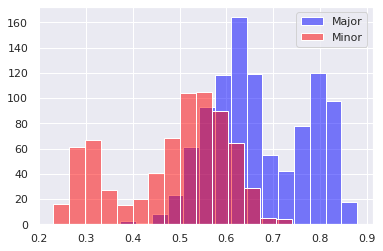

In [7]:
P0 = P_df[T_df == 0]
P1 = P_df[T_df == 1]
treat_plt = plt.hist(P1, fc=(0, 0, 1, 0.5), bins=15, label='Major')
cont_plt = plt.hist(P0, fc=(1, 0, 0, 0.5), bins=15, label='Minor')
plt.legend()
plt.show()

In [8]:
df = df[df['P'] >= 0.4][df['P'] <= 0.7].reset_index()
df.drop(columns=['index'], inplace=True)
x_features = df.columns.difference(['T', 'Y'])
T_df = df['T']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


**Estimating Propensity Score**

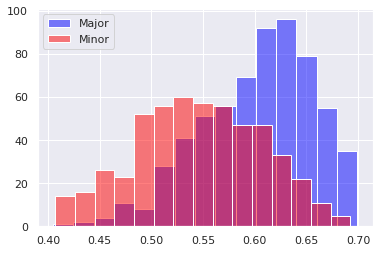

In [9]:
P_df = df['P']
P0 = P_df[T_df == 0]
P1 = P_df[T_df == 1]
treat_plt = plt.hist(P1, fc=(0, 0, 1, 0.5), bins=15, label='Major')
cont_plt = plt.hist(P0, fc=(1, 0, 0, 0.5), bins=15, label='Minor')
plt.legend()
plt.show()

**Estimating ATE**

In [10]:
B = 100
n = 400
squares = [0] * 5
sums = [0] * 5
ipws = [0] * B
ss = [0] * B
ts = [0] * B
matchs = [0] * B
avgs = [0] * B
for b in range(B):
  boot_df = df.sample(n, replace=True).reset_index(inplace=False)
  boot_df.drop(columns=['index'], inplace=True)
  X = boot_df[x_features]
  T_df = boot_df['T']
  Y_df = boot_df['Y']
  P_df = boot_df['P']
  P0 = P_df[T_df == 0]
  P1 = P_df[T_df == 1]
  avg_ate = 0
  # IPW
  ipw_ate = (Y_df[T_df == 1] / P_df[T_df == 1]).sum()/len(X) - (Y_df[T_df == 0] / (1 - P_df[T_df == 0])).sum()/len(X)
  ipws[b] = ipw_ate
  sums[0] += ipw_ate
  squares[0] += ipw_ate ** 2
  avg_ate += ipw_ate
  # S-learner
  X_train = pd.concat([X, T_df], axis=1)
  model = make_pipeline(StandardScaler(), RandomForestRegressor())
  s_model = model.fit(X_train, Y_df)
  treated_df_T0 = X.copy()
  treated_df_T1 = X.copy()
  treated_df_T0['T'] = 0
  treated_df_T1['T'] = 1
  s_ate = ((1 / len(X)) * sum([s_model.predict(treated_df_T1.iloc[[i]]) - s_model.predict(treated_df_T0.iloc[[i]]) for i in range(len(X))]))[0]
  ss[b] = s_ate
  sums[1] += s_ate
  squares[1] += s_ate ** 2
  avg_ate += s_ate
  # T-learner
  X_train0 = X[T_df == 0]
  X_train1 = X[T_df == 1]
  Y_train0 = Y_df[T_df == 0]
  Y_train1 = Y_df[T_df == 1]
  model0 = make_pipeline(StandardScaler(), RandomForestRegressor())
  model1 = make_pipeline(StandardScaler(), RandomForestRegressor())
  t_model0 = model0.fit(X_train0, Y_train0)
  t_model1 = model1.fit(X_train1, Y_train1)
  t_ate = ((1 / len(X)) * sum([t_model1.predict(X.iloc[[i]]) - t_model0.predict(X.iloc[[i]]) for i in range(len(X))]))[0]
  ts[b] = t_ate
  sums[2] += t_ate
  squares[2] += t_ate ** 2
  avg_ate += t_ate
  # Matching
  Y0 = []
  Y1 = []
  for obs in np.random.permutation(T_df[T_df == 1].index):
    dist = abs(P1[obs] - P0)
    Y0.append(Y_df[dist.idxmin()])
    Y1.append(Y_df[obs])
  for obs in np.random.permutation(T_df[T_df == 0].index):
    dist = abs(P1 - P0[obs])
    Y1.append(Y_df[dist.idxmin()])
    Y0.append(Y_df[obs])
  match_ate = (np.array(Y1) - np.array(Y0)).mean()
  matchs[b] = match_ate
  sums[3] += match_ate
  squares[3] += match_ate ** 2
  avg_ate += match_ate
  avg_ate /= 4
  avgs[b] = avg_ate
  sums[4] += avg_ate
  squares[4] += avg_ate ** 2


In [11]:
ses = (np.array(squares)/B - (np.array(sums)/B)**2)**0.5
print("IPW: mean:", np.mean(np.array(ipws)), "ic:", (np.mean(np.array(ipws)) - 2 * ses[0],  np.mean(np.array(ipws)) + 2 * ses[0]))
print("S-learner: mean:", np.mean(np.array(ss)), "ic:", (np.mean(np.array(ss)) - 2 * ses[1],  np.mean(np.array(ss)) + 2 * ses[1]))
print("T-learner: mean:", np.mean(np.array(ts)), "ic:", (np.mean(np.array(ts)) - 2 * ses[2],  np.mean(np.array(ts)) + 2 * ses[2]))
print("Matching: mean:", np.mean(np.array(matchs)), "ic:", (np.mean(np.array(matchs)) - 2 * ses[3],  np.mean(np.array(matchs)) + 2 * ses[3]))
print("Average: mean:", np.mean(np.array(avgs)), "ic:", (np.mean(np.array(avgs)) - 2 * ses[4],  np.mean(np.array(avgs)) + 2 * ses[4]))

IPW: mean: -0.08644909357817264 ic: (-0.23442039753553973, 0.06152221037919446)
S-learner: mean: -0.000924310250000005 ic: (-0.0032959642733990276, 0.0014473437733990178)
T-learner: mean: -0.007113217000000036 ic: (-0.02898995903484937, 0.014763525034849297)
Matching: mean: -0.012156824999999996 ic: (-0.05316956163055783, 0.02885591163055784)
Average: mean: -0.02666086145704316 ic: (-0.0693919707458131, 0.016070247831726774)
